<a href="https://colab.research.google.com/github/TakashiSato/colaboratory/blob/master/NonLinearOptimalControl/Algorithm2.1_SteepestDescentMethod_2link_IK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import numpy as np
import sympy
from sympy import *
import matplotlib.pyplot as plt

In [ ]:
def custom_latex_printer(expr, **options):
    from IPython.display import Math, HTML
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-AMS_CHTML"
    javascript(content="""window.MathJax = {
        tex2jax: {
            inlineMath: [ ['$','$'] ],
            processEscapes: true
        }
        };""")
    javascript(url=url)
    return latex(expr, **options)
init_printing(use_latex="mathjax", latex_printer=custom_latex_printer)

In [ ]:
sympy.var(['theta_1', 'theta_2', 'l_1', 'l_2', 'x', 'y'])

<IPython.core.display.Javascript object>

[θ₁, θ₂, l₁, l₂, x, y]

In [ ]:
# Forward Kinematics
FK = Matrix([[cos(theta_1),cos(theta_1+theta_2)],[sin(theta_1),sin(theta_1+theta_2)]]) * Matrix([[l_1], [l_2]])
FK

<IPython.core.display.Javascript object>

⎡l₁⋅cos(θ₁) + l₂⋅cos(θ₁ + θ₂)⎤
⎢                            ⎥
⎣l₁⋅sin(θ₁) + l₂⋅sin(θ₁ + θ₂)⎦

In [ ]:
X = Matrix([[x], [y]])

## 評価関数

In [ ]:
g = X - FK

In [ ]:
f = g.T * g
f

<IPython.core.display.Javascript object>

⎡                                   2                                      2⎤
⎣(-l₁⋅sin(θ₁) - l₂⋅sin(θ₁ + θ₂) + y)  + (-l₁⋅cos(θ₁) - l₂⋅cos(θ₁ + θ₂) + x) ⎦

## 勾配ベクトル

In [ ]:
rf_rt = Matrix([diff(f, theta_1), diff(f, theta_2)]).T
rf_rt

<IPython.core.display.Javascript object>

[(2⋅l₁⋅sin(θ₁) + 2⋅l₂⋅sin(θ₁ + θ₂))⋅(-l₁⋅cos(θ₁) - l₂⋅cos(θ₁ + θ₂) + x) + (-2⋅
l₁⋅cos(θ₁) - 2⋅l₂⋅cos(θ₁ + θ₂))⋅(-l₁⋅sin(θ₁) - l₂⋅sin(θ₁ + θ₂) + y)  -2⋅l₂⋅(-l
₁⋅sin(θ₁) - l₂⋅sin(θ₁ + θ₂) + y)⋅cos(θ₁ + θ₂) + 2⋅l₂⋅(-l₁⋅cos(θ₁) - l₂⋅cos(θ₁ 
+ θ₂) + x)⋅sin(θ₁ + θ₂)]

## 再急降下法

In [ ]:
def steepest_descent_method(xd, yd, link1_length, link2_length, init_theta_1, init_theta_2, epsilon):

  params = ((l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd))
  FK_s = FK.subs(params)
  # FK_s = FK.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd)])
  rf_rt_s = rf_rt.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd)])
  f_s = f.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd)])
 
  def compute_slope_vector(theta):
    return rf_rt_s.subs([(theta_1, theta[0]), (theta_2, theta[1])])

  def compute_descent_vector(theta):  
    return -compute_slope_vector(theta).T

  def compute_forward_kinematics(theta):  
    return FK_s.subs([(theta_1, theta[0]), (theta_2, theta[1])])

  def compute_eval_value(theta):  
    return f_s.subs([(theta_1, theta[0]), (theta_2, theta[1])])[0]

  # def compute_slope_vector(theta):
  #   return rf_rt.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd), (theta_1, theta[0]), (theta_2, theta[1])])

  # def compute_descent_vector(theta):  
  #   return -compute_slope_vector(theta).T

  # def compute_forward_kinematics(theta):  
  #   return FK.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd), (theta_1, theta[0]), (theta_2, theta[1])])

  # def compute_eval_value(theta):  
  #   return f.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd), (theta_1, theta[0]), (theta_2, theta[1])])[0]

  theta = Matrix([init_theta_1, init_theta_2])
  for i in range(100):
    slope = compute_slope_vector(theta)
    slope_norm = slope.norm()
    if slope_norm < epsilon:
      break
    s = compute_descent_vector(theta)

    # 直線探索
    eval_min = sys.float_info.max
    alpha_star = 0.
    for alpha in np.linspace(0.0, 1.0, 10):
      temp_theta = theta + alpha * s
      eval_value = compute_eval_value(temp_theta)
      if eval_value < eval_min:
        eval_min = eval_value
        alpha_star = alpha
    theta = theta + alpha_star * s
    fk = compute_forward_kinematics(theta)

    print('[%d] FK: [%f, %f], theta: [%f, %f], alpha: %f, s: [%f, %f], eval_value: %f, slope_norm: %f' % (i, fk[0], fk[1], theta[0], theta[1], min_alpha, s[0], s[1], eval_min, slope_norm))

  print('==== Result ====')
  theta = np.array(theta).astype(np.float64)
  print('[%d] FK: [%f, %f], theta: [%f, %f (rad): %f, %f (deg)], eval_value: %f, slope_norm: %f' % (i, fk[0], fk[1], theta[0], theta[1], np.degrees(theta[0]), np.degrees(theta[1]), compute_eval_value(theta), slope_norm))
  return theta

In [ ]:
def steepest_descent_method(f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100):
 
  # slope_symbols = sympy.tensor.array.derive_by_array(f_symbols, x_symbols)
  slope_symbols = sympy.zeros(len(vars),1)
  for i in range(len(x_symbols)):
    slope_symbols[i] = diff(f_symbols, x_symbols[i])

  for i in range(max_iteration):
    slope =  slope_symbols.subs(list(zip(x_symbols, x0)))
    if slope.norm() < epsilon:
      break
    s = -slope

    # 直線探索
    eval_min = sys.float_info.max
    alpha_star = 0.
    for alpha in np.linspace(0.0, 1.0, 10):
      x_temp = x0 + alpha * s
      eval_value = f_symbols.subs(list(zip(x_symbols, x_temp)))
      if eval_value < eval_min:
        eval_min = eval_value
        alpha_star = alpha
    x0 = x0 + alpha_star * s
    print(i, x0, eval_value)
    
  return np.array(x0).astype(np.float64)

## 具体値計算

0 Matrix([[0.256368336307576], [0.714013407038795]]) 0.379256314244286
1 Matrix([[0.213352489008573], [0.691723273551535]]) 0.00401663921919503
2 Matrix([[0.212746194708764], [0.690927768170921]]) 6.88849113878712e-6
3 Matrix([[0.213437214672258], [0.690433611948529]]) 5.74350039155105e-6
4 Matrix([[0.213340086543385], [0.689574238329727]]) 5.26348559019202e-6
5 Matrix([[0.214178436808707], [0.689232725271548]]) 4.84311452275931e-6
6 Matrix([[0.213908429044436], [0.688521495117323]]) 4.48521461820120e-6
7 Matrix([[0.214672393642019], [0.688203899566814]]) 4.10487010459476e-6
8 Matrix([[0.214430595661068], [0.687553165580954]]) 3.80073214601205e-6
9 Matrix([[0.215127186424646], [0.687257860944109]]) 3.48089638549061e-6
10 Matrix([[0.214910531352907], [0.686662183878450]]) 3.22232715650643e-6
11 Matrix([[0.215546035683131], [0.686387645953640]]) 2.95312584440357e-6
12 Matrix([[0.215351814646597], [0.685842120176041]]) 2.73320606144444e-6
13 Matrix([[0.215931880130558], [0.685586922422118

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


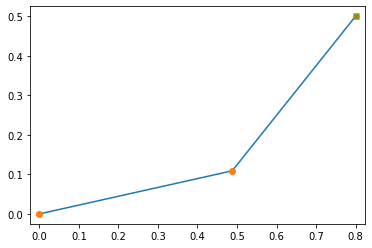

In [ ]:
link1_length = 0.5
link2_length = 0.5
xd = 0.8
yd = 0.5

init_theta_1 = 1.0
init_theta_2 = 1.0
epsilon = 1e-4

def plot_result(theta):
  def compute_forward_kinematics(theta):  
    fk = FK.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd), (theta_1, theta[0]), (theta_2, theta[1])])
    return np.array(fk.T).astype(np.float64)[0]

  fk = compute_forward_kinematics(theta)
  fk_link1 = [link1_length*np.cos(theta[0]), link1_length*np.sin(theta[0])]
  plt.plot([0, fk_link1[0], fk[0]], [0, fk_link1[1], fk[1]])
  plt.plot([0, fk_link1[0], fk[0]], [0, fk_link1[1], fk[1]], 'o')
  plt.plot(xd, yd, 'x')
  plt.axes().set_aspect('equal', 'datalim')

# theta = steepest_descent_method(xd, yd, link1_length, link2_length, init_theta_1, init_theta_2, epsilon)
known_values = ((l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd))
vars = Matrix([theta_1, theta_2])
vars_init = Matrix([init_theta_1, init_theta_2])

# f2 = f.subs(known_values)
# f2.subs(zip(vars, vars_init))
theta_star = steepest_descent_method(f.subs(known_values)[0], vars, vars_init, epsilon)
plot_result(theta_star)